In [346]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import math
import cv2

In [347]:
class Particle():
    def __init__(self, pose):
        self.pose = pose # (x, y, theta)
        self.weight = 0

class Map():
    def __init__(self, map, width, height, resolution):
        self.data = map
        self.width = width
        self.height = height
        self.resolution = resolution
        
    @staticmethod
    def load_map(filename):
        im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY)
        return Map(im_bw, im_bw.shape[0], im_bw.shape[1], 1)

class Scan():
    def __init__(self, angle_min, angle_max, angle_increment, ranges, range_max):
        self.angle_min = angle_min
        self.angle_max = angle_max
        self.angle_increment = angle_increment
        assert((angle_max - angle_min) / angle_increment == len(ranges))
        self.ranges = ranges
        self.range_max = range_max

class LikelihoodField():
    def __init__(self, map):
        # For all cells in map, pre-compute distance to nearest occupied cell
        total_occupied_cells = np.count_nonzero(map.data == 0)
        print(total_occupied_cells)

        occupied_cells = np.argwhere(map.data == 0)
        nbrs = NearestNeighbors(n_neighbors=1).fit(occupied_cells)

        # Coordinate of all grid cells
        X = np.argwhere(np.isreal(map.data))
        dist, idx = nbrs.kneighbors(X)

        self.closest_obstacle = dist.reshape(map.data.shape)
    def closest_obstacle_to_pose(self, x, y):
        return self.closest_obstacle[np.round(x), np.round(y)]

class OccupancyGrid():
    def __init__(self):
        # Defined in meters
        self.map_size = (100, 100)
        self.map_resolution = 1/5
        self.map_origin = (0,0)
        self.log_prob_map = np.zeros([
            int(self.map_size[0] / self.map_resolution),
            int(self.map_size[1] / self.map_resolution)], 
            dtype=np.float32
        )
        self.test_map = np.zeros([
            int(self.map_size[0] / self.map_resolution),
            int(self.map_size[1] / self.map_resolution)], 
            dtype=np.float32
        )
        
    def coordinate_to_cell(self, x, y):
        return (
            (x - self.map_origin[0]) / self.map_resolution,
            (y - self.map_origin[1]) / self.map_resolution
        )
    
    def is_valid_cell_coordinate(self, coordinate):
        x_c, y_c = coordinate
        return (
                (0 < x_c < self.log_prob_map.shape[0]) and
                (0 < y_c < self.log_prob_map.shape[1])
        )
    
    # Returns grid cells between points using Bresenham's line algorithm
    # https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    @staticmethod
    def bresenham_line(x0, y0, x1, y1):
        points = []
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        x, y = x0, y0
        sx = -1 if x0 > x1 else 1
        sy = -1 if y0 > y1 else 1
        
        if dx > dy:
            err = dx / 2.0
            while x != x1:
                points.append((x, y))
                err -= dy
                if err < 0:
                    y += sy
                    err += dx
                x += sx
        else:
            err = dy / 2.0
            while y != y1:
                points.append((x, y))
                err -= dx
                if err < 0:
                    x += sx
                    err += dy
                y += sy        
        points.append((x, y))
        return np.array(points)
    
    # Converts a laser scan around pose and returns a 2D array where each point represents where a laser beam has hit an obstacle.
    def process_scan(self, pose, scan: Scan):
        x, y, theta = pose
        
        scan_angles = np.arange(scan.angle_min, scan.angle_max, scan.angle_increment)
        return np.array((
            x + scan.ranges * np.cos(scan_angles + theta),
            y + scan.ranges * np.sin(scan_angles + theta)
        )).T
    
    def update_cells(self, pose, scan):
        x, y, theta = pose
        # Get the occupied cells from scans with an obstacle
        obstacle_cells = self.process_scan(pose, scan)
        
        # Free cells are now given by pose and line drawn from pose to obstacle_cells
        free_cells = np.array([[x, y], [x, y]])
        for i, (x_obstacle, y_obstacle) in enumerate(obstacle_cells):
            x_c, y_c = self.coordinate_to_cell(x_obstacle, y_obstacle)
            if scan.ranges[i] >= scan.range_max or not self.is_valid_cell_coordinate((x_c, y_c)):
                continue
            free_cells = np.vstack((free_cells, 
                                   OccupancyGrid.bresenham_line(
                                       *np.round(self.coordinate_to_cell(x, y)),
                                       np.round(x_c), np.round(y_c))))
            
        return [self.coordinate_to_cell(x, y) for (x, y) in obstacle_cells], free_cells
    
    @staticmethod
    # Returns the log prob of an occupied cell or free cell
    def prob(occupied):
        probability = 0.75
        A, B = probability, 1 - probability
        if occupied:
            return np.log(B / A)
        else:
            return np.log(A / B)
            
    def get_map(self):
        return 1 - 1 / (1 + np.exp(np.clip(self.log_prob_map, -10, 10)))
    
    def update(self, pose, scan: Scan):
        obstacle_cells, free_cells = self.update_cells(pose, scan)
        for (x, y) in filter(self.is_valid_cell_coordinate, obstacle_cells):
            self.log_prob_map[int(x), int(y)] += self.prob(True)
            self.test_map[int(x), int(y)] = 1
        for (x, y) in filter(self.is_valid_cell_coordinate, free_cells):
            self.log_prob_map[int(x), int(y)] += self.prob(False)
            self.test_map[int(x), int(y)] = 0
        
# Probabilistic robotics, Table 13.4 P 478
class FastSLAM():
    def __init__(self):
        self.dt = 0.01
        self.num_particles = 50
    
    def sample_normal(self, b):
        return np.random.normal(loc=0.0, scale=max(1e-6, np.sqrt(b)))

    def plot_particles(self, particles):
        fig, ax = plt.subplots()
        for particle in particles:
            ax.scatter(particle.pose[0], particle.pose[1], c='r', marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Particle Poses')
        
        plt.show()
        
    # Given state x (x,y,theta) and control u (v, omega), sample a pose.
    def sample_motion_model(self, u, x):
        x, y, theta = x
        v, omega = u

        # Parameters of motion noise.
        a1, a2, a3, a4, a5, a6 = [0.01] * 6
        
        v_hat = v + self.sample_normal(a1 * (v ** 2) + a2 * (omega ** 2))
        omega_hat = omega + self.sample_normal(a3 * (v ** 2) + a4 * (omega ** 2))
        gamma_hat = self.sample_normal(a5 * (v ** 2) + a6 * (omega ** 2))

        x_prime = x - (v_hat / omega_hat) * np.sin(theta) + (v_hat / omega_hat) * np.sin(theta + omega_hat * self.dt)
        y_prime = y + (v_hat / omega_hat) * np.cos(theta) - (v_hat / omega_hat) * np.cos(theta + omega_hat * self.dt)
        theta_prime = theta + omega_hat * self.dt + gamma_hat * self.dt
        return np.array([x_prime, y_prime, theta_prime])

    @staticmethod
    def prob_centered_gaussian(dist, std_dev):
        c = 1.0 / (sd * np.sqrt(2 * math.pi))
        prob = c * math.exp((-math.pow(dist,2))/(2 * math.pow(sd, 2)))
        return prob
        
    # Computes range model using liklihood field 
    # Given scan, pose and map
    # Table 6.3 P.143
    def measurement_model_map(self, scan: Scan, pose, like_field: LikelihoodField):
        x, y, theta = pose
        q = 1
        for i, range in enumerate(scan.ranges):
            if range >= scan.range_max:
                continue
                
            angle = (i * scan.angle_increment) + scan.angle_min
            assert(angle < scan.angle_max)
            angle += theta

            # Get the reported position of the obstacle
            x_z = x + range * np.cos(angle)
            y_z = y + range * np.sin(angle)

            # Now get the distance to the closest obstacle
            distance = like_field.closest_obstacle_to_pose(x_z, y_z)

            # Update probability, this is using the simplified model, without taking into account z_random and z_max
            # TODO, Maybe implement this?
            q = q * FastSLAM.prob_centered_gaussian(distance, 0.01)
        return q

    def update(self, u, pose):
        # Sample motion model and create particles
        # particles = [Particle(slam.sample_motion_model(u), pose))) for _ in range(self.num_particles)]
        pass

In [369]:
# Load from dataset for testing
def load_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    laser_data = []
    odometry_data = []
    
    for line in lines:
        if line.startswith('FLASER'):
            line = line.strip().split()
            num_laser_values = int(line[1])  # Extracting number of laser values
            values = line[2:]  # Extracting laser and odometry values
            max_range = 10
            scan_data = np.clip([float(value) for value in values[:num_laser_values]], 0, max_range + 1)
            scan = Scan(angle_min=-np.pi/2, angle_max=np.pi/2, range_max=max_range, angle_increment=(1 * np.pi) / float(num_laser_values), ranges=scan_data)
            laser_data.append(scan)
            #laser_data.append(scan_data)
            odometry_data.append([float(value) for value in values[num_laser_values:num_laser_values+3]])
    
    return np.array(laser_data), np.array(odometry_data)
scans, poses = load_dataset('orebro.gfs.log')

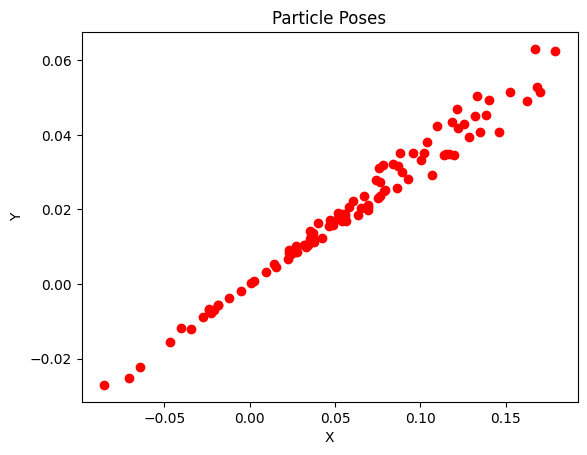

In [349]:
slam = FastSLAM()
particles = [Particle(slam.sample_motion_model(np.array([5,65]), np.array([0,0,0]))) for _ in range(100)]
slam.plot_particles(particles)

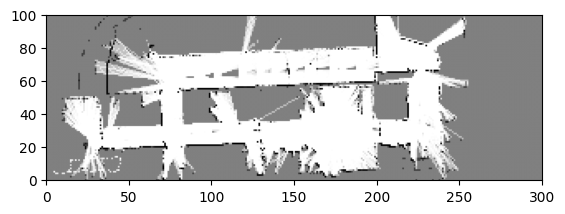

In [370]:
grid = OccupancyGrid()
for i in range(100):
    grid.update(poses[i] + np.array([5, 5, 0]), scans[i])
    plt.imshow(grid.get_map(), cmap='gray')
    ax = plt.gca()
    ax.set_xlim([0, 300])
    ax.set_ylim([0, 100])
    plt.savefig('out/%03d.png' % i)

In [351]:
out_map != 0.5

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [352]:
map = Map.load_map("test_map.png")
LikelihoodField(map)

1756


In [353]:
total_occupied_cells = np.count_nonzero(map.data == 0)
print(total_occupied_cells)

occupied_cells = np.argwhere(map.data == 0)
nbrs = NearestNeighbors(n_neighbors=1).fit(occupied_cells)
X = np.argwhere(np.isreal(map.data))
dist, idx = nbrs.kneighbors(X)
dist.reshape(map.data.shape)[0,0]

1756


32.802438933713454